In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.0114

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 587ms/step - loss: 0.0098
Average validation loss: 0.14110414683818817
4/4 [==============================] - 6s 604ms/step - loss: 0.0098 - val_loss: 0.1411
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 597ms/step - loss: 0.0073 - val_loss: 0.1411
Average validation loss: 0.13848447799682617
4/4 [==============================] - 8s 610ms/step - loss: 0.0073 - val_loss: 0.1398
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 611ms/step - loss: 0.0055 - val_loss: 0.1398
Average validation loss: 0.127711221575737
4/4 [==============================] - 11s 626ms/step - loss: 0.0055 - val_loss: 0.1358
Saved model weights to 'c:\Users\user\Desktop\天_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 786ms/step - loss: 3.9922e-04
Average validation loss: 0.21356730163097382
8/8 [==============================] - 6s 802ms/step - loss: 3.9922e-04 - val_loss: 0.2136
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 767ms/step - loss: 4.0047e-04 - val_loss: 0.2136
Average validation loss: 0.29291215538978577
8/8 [==============================] - 13s 781ms/step - loss: 4.0047e-04 - val_loss: 0.2532
Epoch 3/10
8/8 [==============================] - 19s 807ms/step - loss: 4.0021e-04 - val_loss: 0.2532
Average validation loss: 0.1557278409600258
8/8 [==============================] - 19s 824ms/step - loss: 4.0021e-04 - val_loss: 0.2207
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_10.pth'.
Epoch 4/10
8/8 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 729ms/step - loss: 5.2350e-04
Average validation loss: 0.1732450077931086
12/12 [==============================] - 9s 740ms/step - loss: 5.2350e-04 - val_loss: 0.1732
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 711ms/step - loss: 5.0440e-04 - val_loss: 0.1732
Average validation loss: 0.0925763597091039
12/12 [==============================] - 18s 724ms/step - loss: 5.0440e-04 - val_loss: 0.1329
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 704ms/step - loss: 5.0588e-04 - val_loss: 0.1329
Average validation loss: 0.12668482959270477
12/12 [==============================] - 26s 718ms/step - loss: 5.0588e-04 - val_loss: 0.1308
Epoch 4/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 718ms/step - loss: 4.5192e-04
Average validation loss: 0.09596831537783146
16/16 [==============================] - 12s 731ms/step - loss: 4.5192e-04 - val_loss: 0.0960
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 726ms/step - loss: 4.3213e-04 - val_loss: 0.0960
Average validation loss: 0.103487154468894
16/16 [==============================] - 24s 738ms/step - loss: 4.3213e-04 - val_loss: 0.0997
Epoch 3/10
16/16 [==============================] - 35s 719ms/step - loss: 4.2173e-04 - val_loss: 0.0997
Average validation loss: 0.10523450374603271
16/16 [==============================] - 35s 731ms/step - loss: 4.2173e-04 - val_loss: 0.1016
Epoch 4/10
16/16 [==============================] - 47s 727ms/step - loss: 4.1753e-04 - val_loss: 0.1016
Average validation loss: 0.09621697664260864
16/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 718ms/step - loss: 3.0285e-04
Average validation loss: 0.10751875191926956
20/20 [==============================] - 15s 729ms/step - loss: 3.0285e-04 - val_loss: 0.1075
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 707ms/step - loss: 2.8929e-04 - val_loss: 0.1075
Average validation loss: 0.10520285815000534
20/20 [==============================] - 29s 720ms/step - loss: 2.8929e-04 - val_loss: 0.1064
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 709ms/step - loss: 2.7702e-04 - val_loss: 0.1064
Average validation loss: 0.10068161934614181
20/20 [==============================] - 44s 720ms/step - loss: 2.7702e-04 - val_loss: 0.1045
Save

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 712ms/step - loss: 2.9604e-04
Average validation loss: 0.11838335668047269
24/24 [==============================] - 17s 725ms/step - loss: 2.9604e-04 - val_loss: 0.1184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 710ms/step - loss: 2.6153e-04 - val_loss: 0.1184
Average validation loss: 0.08435380334655444
24/24 [==============================] - 35s 721ms/step - loss: 2.6153e-04 - val_loss: 0.1014
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 714ms/step - loss: 2.5077e-04 - val_loss: 0.1014
Average validation loss: 0.09878567978739738
24/24 [==============================] - 52s 725ms/step - loss: 2.5077e-04 - val_loss: 0.1005
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 727ms/step - loss: 3.4357e-04
Average validation loss: 0.08851467445492744
40/40 [==============================] - 30s 739ms/step - loss: 3.4357e-04 - val_loss: 0.0885
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 719ms/step - loss: 3.1840e-04 - val_loss: 0.0885
Average validation loss: 0.10984570533037186
40/40 [==============================] - 59s 730ms/step - loss: 3.1840e-04 - val_loss: 0.0992
Epoch 3/10
40/40 [==============================] - 88s 719ms/step - loss: 3.0567e-04 - val_loss: 0.0992
Average validation loss: 0.10914483591914177
40/40 [==============================] - 88s 731ms/step - loss: 3.0567e-04 - val_loss: 0.1025
Epoch 4/10
40/40 [==============================] - 117s 720ms/step - loss: 2.9238e-04 - val_loss: 0.1025
Average validation loss: 0.10149079114198685


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 719ms/step - loss: 2.3465e-04
Average validation loss: 0.09710340946912766
48/48 [==============================] - 35s 731ms/step - loss: 2.3465e-04 - val_loss: 0.0971
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 729ms/step - loss: 2.0835e-04 - val_loss: 0.0971
Average validation loss: 0.09964273311197758
48/48 [==============================] - 71s 742ms/step - loss: 2.0835e-04 - val_loss: 0.0984
Epoch 3/10
48/48 [==============================] - 105s 719ms/step - loss: 1.9177e-04 - val_loss: 0.0984
Average validation loss: 0.09462552269299825
48/48 [==============================] - 106s 730ms/step - loss: 1.9177e-04 - val_loss: 0.0971
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_60.pth'.
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 727ms/step - loss: 2.3914e-04
Average validation loss: 0.09439377593142646
56/56 [==============================] - 41s 739ms/step - loss: 2.3914e-04 - val_loss: 0.0944
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 718ms/step - loss: 2.2027e-04 - val_loss: 0.0944
Average validation loss: 0.09593208506703377
56/56 [==============================] - 82s 730ms/step - loss: 2.2027e-04 - val_loss: 0.0952
Epoch 3/10
56/56 [==============================] - 122s 715ms/step - loss: 2.0325e-04 - val_loss: 0.0952
Average validation loss: 0.09652224768485342
56/56 [==============================] - 123s 728ms/step - loss: 2.0325e-04 - val_loss: 0.0956
Epoch 4/10
56/56 [==============================] - 164s 721ms/step - loss: 1.8889e-04 - val_loss: 0.0956
Average validation loss: 0.0954583281917231

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 699ms/step - loss: 2.2653e-04
Average validation loss: 0.09093657275661826
64/64 [==============================] - 45s 710ms/step - loss: 2.2653e-04 - val_loss: 0.0909
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 699ms/step - loss: 1.9063e-04 - val_loss: 0.0909
Average validation loss: 0.09553494909778237
64/64 [==============================] - 91s 711ms/step - loss: 1.9063e-04 - val_loss: 0.0932
Epoch 3/10
64/64 [==============================] - 136s 697ms/step - loss: 1.6881e-04 - val_loss: 0.0932
Average validation loss: 0.09023693157359958
64/64 [==============================] - 136s 708ms/step - loss: 1.6881e-04 - val_loss: 0.0922
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_80.pth'.
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 696ms/step - loss: 1.8701e-04
Average validation loss: 0.09683623082107967
72/72 [==============================] - 51s 707ms/step - loss: 1.8701e-04 - val_loss: 0.0968
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 699ms/step - loss: 1.6591e-04 - val_loss: 0.0968
Average validation loss: 0.09279964284764396
72/72 [==============================] - 102s 710ms/step - loss: 1.6591e-04 - val_loss: 0.0948
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 153s 701ms/step - loss: 1.4869e-04 - val_loss: 0.0948
Average validation loss: 0.08977086676491632
72/72 [==============================] - 154s 712ms/step - loss: 1.4869e-04 - val_loss: 0.0931


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 62s 778ms/step - loss: 1.6261e-04
Average validation loss: 0.09400056339800358
80/80 [==============================] - 63s 790ms/step - loss: 1.6261e-04 - val_loss: 0.0940
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 125s 768ms/step - loss: 1.4666e-04 - val_loss: 0.0940
Average validation loss: 0.0892462681978941
80/80 [==============================] - 126s 781ms/step - loss: 1.4666e-04 - val_loss: 0.0916
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 187s 765ms/step - loss: 1.3439e-04 - val_loss: 0.0916
Average validation loss: 0.09480800330638886
80/80 [==============================] - 188s 778ms/step - loss: 1.3439e-04 - val_loss: 0.0927

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 75s 779ms/step - loss: 2.5299e-04
Average validation loss: 0.08935266857345898
96/96 [==============================] - 76s 791ms/step - loss: 2.5299e-04 - val_loss: 0.0894
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 151s 780ms/step - loss: 2.0218e-04 - val_loss: 0.0894
Average validation loss: 0.09009198937565088
96/96 [==============================] - 152s 793ms/step - loss: 2.0218e-04 - val_loss: 0.0897
Epoch 3/10
96/96 [==============================] - 227s 776ms/step - loss: 1.7758e-04 - val_loss: 0.0897
Average validation loss: 0.08793359342962503
96/96 [==============================] - 228s 789ms/step - loss: 1.7758e-04 - val_loss: 0.0891
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_120.pth'

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 709ms/step - loss: 1.9143e-04
Average validation loss: 0.09327223747968674
120/120 [==============================] - 86s 721ms/step - loss: 1.9143e-04 - val_loss: 0.0933
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 172s 710ms/step - loss: 1.6804e-04 - val_loss: 0.0933
Average validation loss: 0.0892143743733565
120/120 [==============================] - 173s 721ms/step - loss: 1.6804e-04 - val_loss: 0.0912
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 258s 710ms/step - loss: 1.5143e-04 - val_loss: 0.0912
Average validation loss: 0.09238870566089948
120/120 [==============================] - 260s 722ms/step - loss: 1.5143e-04 - val_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 718ms/step - loss: 1.7519e-04
Average validation loss: 0.09087662771344185
144/144 [==============================] - 105s 730ms/step - loss: 1.7519e-04 - val_loss: 0.0909
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 715ms/step - loss: 1.5412e-04 - val_loss: 0.0909
Average validation loss: 0.09267227393057612
144/144 [==============================] - 210s 726ms/step - loss: 1.5412e-04 - val_loss: 0.0918
Epoch 3/10
144/144 [==============================] - 313s 719ms/step - loss: 1.4043e-04 - val_loss: 0.0918
Average validation loss: 0.09383361952172385
144/144 [==============================] - 315s 731ms/step - loss: 1.4043e-04 - val_loss: 0.0925
Epoch 4/10
144/144 [==============================] - 418s 718ms/step - loss: 1.3167e-04 - val_loss: 0.0925
Average validation loss:

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 719ms/step - loss: 1.5838e-04
Average validation loss: 0.0952631775289774
160/160 [==============================] - 117s 731ms/step - loss: 1.5838e-04 - val_loss: 0.0953
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 714ms/step - loss: 1.4648e-04 - val_loss: 0.0953
Average validation loss: 0.0937552435323596
160/160 [==============================] - 233s 725ms/step - loss: 1.4648e-04 - val_loss: 0.0945
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 715ms/step - loss: 1.3478e-04 - val_loss: 0.0945
Average validation loss: 0.09702673256397247
160/160 [==============================] - 349s 726ms/step - loss: 1.3478e-04 - val

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 705ms/step - loss: 2.3883e-04
Average validation loss: 0.09674090072512627
200/200 [==============================] - 143s 716ms/step - loss: 2.3883e-04 - val_loss: 0.0967
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 284s 704ms/step - loss: 2.0457e-04 - val_loss: 0.0967
Average validation loss: 0.08909988522529602
200/200 [==============================] - 286s 715ms/step - loss: 2.0457e-04 - val_loss: 0.0929
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 427s 706ms/step - loss: 1.8597e-04 - val_loss: 0.0929
Average validation loss: 0.09184752270579338
200/200 [==============================] - 430s 717ms/step - loss: 1.8597e-04 - v

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:55 - loss: 3.2107e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 718ms/step - loss: 1.7577e-04
Average validation loss: 0.09225080572068692
240/240 [==============================] - 175s 729ms/step - loss: 1.7577e-04 - val_loss: 0.0923
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 344s 703ms/step - loss: 1.5460e-04 - val_loss: 0.0923
Average validation loss: 0.09069498504201572
240/240 [==============================] - 346s 714ms/step - loss: 1.5460e-04 - val_loss: 0.0915
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_90\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 516s 704ms/step - loss: 1.4040e-04 - val_loss: 0.0915
Average validation loss: 0.09235544502735138
240/240 [==============================] - 518s 715ms/step - loss: 1.4040e-04 - v

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08909824329486582, 0.12569470562040805, 0.10625630895296732, 0.09716033041477204, 0.09989911705255508, 0.10027589557071527, 0.09829762801527975, 0.09514082877586284, 0.09285152081932342, 0.09288225473836065, 0.09409350140227211, 0.09305148979276417, 0.09253230802714826, 0.09370206822454931, 0.09295431063820919, 0.09319800596311689, 0.09313886429965496, 0.09393818294505278]
std_val_losses =  [0.06796434676812237, 0.05360478612701377, 0.027862925202766058, 0.010708730810859348, 0.009503625766869908, 0.01080595375381938, 0.006340757321467808, 0.005221221617666, 0.002397510076167521, 0.002878514450250558, 0.0025589301740041818, 0.002262416563611687, 0.002988783053339436, 0.0028719447427847525, 0.0023865800931784243, 0.0029750072091037855, 0.0026723974693743887, 0.0026301989394031857]


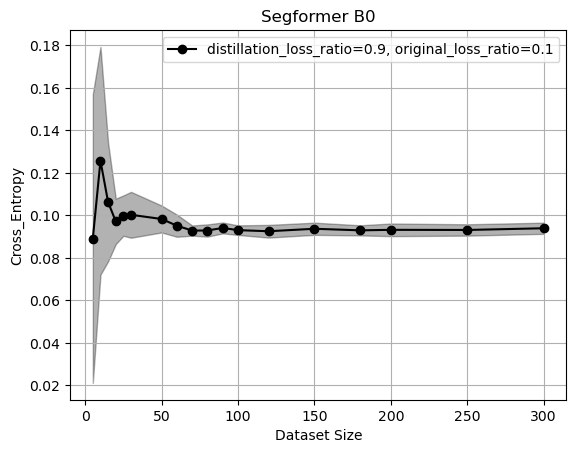

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()